# Model Examination of Features through MAgEC

The Model Agnositc Effect Coefficients (MAgEC) technique offers an intuitive way for examining feature importance through the sample population. We use this notebook to demonstrate the importance of model evaluation and feature evaluation for any healthcare study. The introduction of an artificial variable helps elucidate this by encouraging models to dismiss other features that can be intervened on.

This random variable, in practice, can represent one of many problematic measurements stemming from, for example: data errors, data leakage, confouding variables, non-independent measurements, and so on. In this notebook, we demonstrate 3 artificial variables in 3 pipelines, where each artificial variable is highly correlated to a different feature (plus some random noise). 

In total, there are 4 scenarios:

1) No artificial variable - baseline.

2) Artificial variable highly correlated to the target Outcome.

3) Artificial variable linearly correlated to most important real feature.

4) Artificial variable non-linearly correlated to a combination of the 3 top important features.

In [1]:
import sys
import warnings
import pandas as pd
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
%matplotlib inline
warnings.filterwarnings('ignore') 

In [2]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/magec_utils')
  diabetes_fpath = '/content/drive/My Drive/Colab Notebooks/magec_utils/diabetes.csv'
else:
  sys.path.insert(0,'./magec_utils')
  diabetes_fpath = 'diabetes.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import magec_utils as mg
import pima_utils as pm

### PIMA Dataset
768 females of age greater than 20.(Smith et al, 1988) and a binary target variable marking whether that woman developed type 2 diabetes within the next 5 years. 

    Pregnancies: Number of times pregnant
    Glucose: Plasma glucose concentration at 2 hours in an oral glucose tolerance test
    BloodPressure: Diastolic blood pressure (mm Hg)
    SkinThickness: Triceps skin fold thickness (mm)
    Insulin: 2-Hour serum insulin (mu U/ml)
    BMI: Body mass index (weight in kg/(height in m)^2)
    DiabetesPedigreeFunction: Diabetes pedigree function
    Age: Age (years)
    Outcome: Class variable (0 or 1), indicating the onset of non-insulin-dependent diabetes mellitus (DM) within a five-year period


### Scenario 1 - Baseline

Here we do not introduce any new variables. The code below gives gives a high level workflow for generating the following outputs:

1) feature histograms for all features.

2) sorted feature importances generated through a Random Forest model.

3) The sorted MAgEC feature importances for each individual model for diabetic individuals and non-diabetic individuals. Note, more negative values equate to greater feature importance.

4) The sorted MAgEC feature importances scored through for all models combined. Note, in this case the more positive values equate to greater feature importance.

5) Case-level bar-plots of the top 5 most confident predictions that were incorrect (left) and correct (right). The vertcal axis represents the amount of deviation for the mean for each feature.

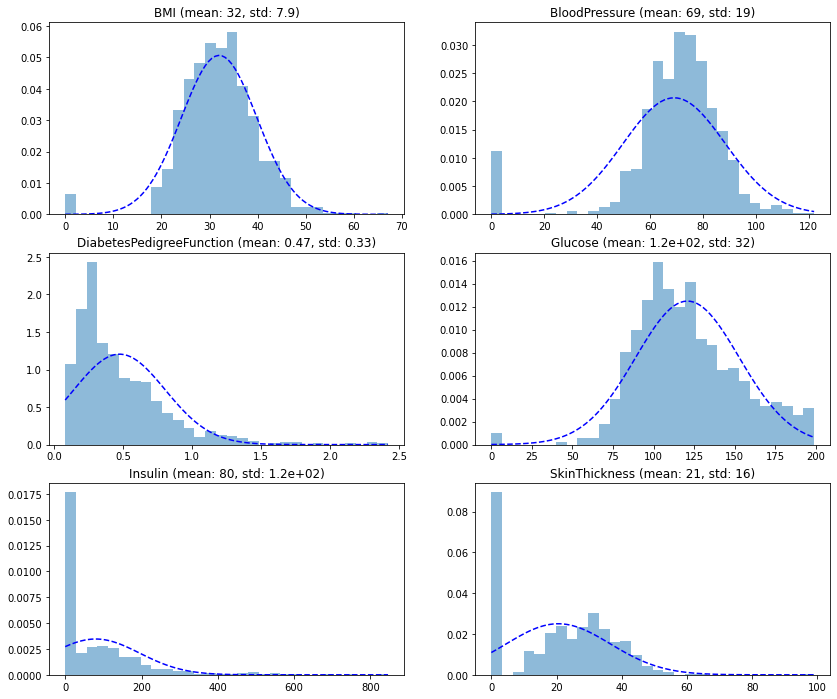

Sorted feature importance from Random Forest Classifier:
0.24239423923583947 -- Glucose
0.16535835078608993 -- BMI
0.13131228248457086 -- DiabetesPedigreeFunction
0.12930062785000895 -- Age
0.0929948846060105 -- Insulin
0.0820028176397164 -- SkinThickness
0.08195636596587659 -- BloodPressure
0.07468043143188732 -- Pregnancies
----------------------------------------------------------------------

MAgEC feature importance by mlp model:
For diabetic individuals
               mlp_magec_1
mlp_feat_1                
Glucose          -0.710638
BloodPressure    -0.338777
BMI              -0.326207
Insulin          -0.281919
SkinThickness    -0.005421

For non-diabetic individuals
               mlp_magec_1
mlp_feat_1                
Glucose          -0.433421
BMI              -0.382050
BloodPressure    -0.189460
SkinThickness    -0.161333
Insulin          -0.148526
not_found              NaN
----------------------------------------------------------------------

MAgEC feature importance by r

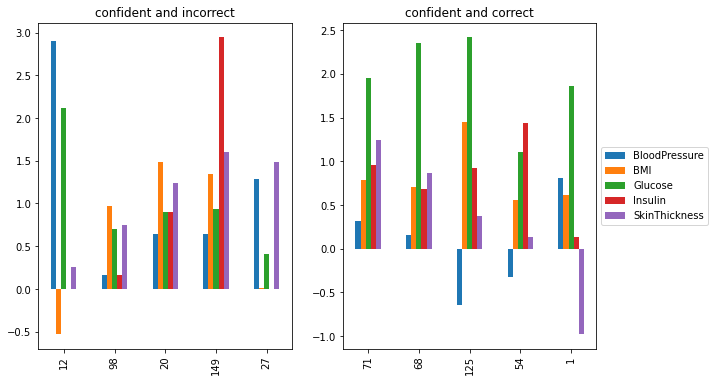

In [4]:
pima, x_train, x_validation, stsc, x_train_p, x_validation_p, y_train_p, y_validation_p = pm.pima_data(diabetes_fpath)
mg.get_data_importance(pima, x_train_p, y_train_p)

models_dict = pm.pima_models(x_train_p, y_train_p)

features = ['BloodPressure', 'BMI', 'Glucose', 'Insulin', 'SkinThickness']

magecs_mlp, magecs_rf, magecs_svm = mg.generate_mlp_rf_svm_magecs(x_validation_p, y_validation_p, models_dict)
joined = mg.magec_models(magecs_mlp, magecs_rf, magecs_svm, Xdata=x_validation_p, Ydata=y_validation_p, features=features)

models = ('mlp', 'rf', 'svm')
weights=dict.fromkeys(models, None)
ranks = mg.magec_rank(joined, models=models, rank=len(features), features=features)
mg.magec_top_important_features_per_model(ranks, models, weights)

consensus_auc = mg.magec_consensus(ranks, use_weights=True, models=models, weights=weights)
mg.show_magec_feature_importance(features, consensus_auc, x_validation_p, y_validation_p)
mg.plot_top_confident_cases(features, consensus_auc, x_validation_p, y_validation_p)


Here we see that each feature has a fairly normal distribution. A Random Forest classifier shows that the top 3 intervenable features are Glucose, BMI, and Insulin. This corresponds to each individual model's MAgEC feature importance for diabetic individuals, as well as the combined models MAgEC feature importance. The bar plots illustrate that BMI, Glucose, and Insulin drove the positive outcome prediction the most for the correct cases.

### Scenario 2 - Outcomes correlated artificial feature

Here we introduce a new feature that is highly correlated to the Outcome (target) feature, with some noise. We call this feature GoodRandVar. Another feature is introduced called BadRandVar, which is just pure noise. The GoodRandVar artificial feature can represent data leakage of the target variable being introduced into the training features. 

Sorted feature importance from Random Forest Classifier:
0.7589585456141376 -- GoodRandVar
0.09036364862578988 -- Glucose
0.043409727803788226 -- BMI
0.028491036236083532 -- Age
0.020710922981149894 -- Insulin
0.017867287111082628 -- DiabetesPedigreeFunction
0.013028136141497476 -- SkinThickness
0.00973621636380009 -- Pregnancies
0.00956643635280745 -- BadRandVar
0.007868042769863394 -- BloodPressure
----------------------------------------------------------------------

MAgEC feature importance by mlp model:
For diabetic individuals
             mlp_magec_1
mlp_feat_1              
GoodRandVar    -0.983802

For non-diabetic individuals
               mlp_magec_1
mlp_feat_1                
BMI              -0.056065
Glucose          -0.043037
BloodPressure    -0.041128
BadRandVar       -0.039156
SkinThickness    -0.028034
Insulin          -0.027290
not_found              NaN
----------------------------------------------------------------------

MAgEC feature importance by rf model:
Fo

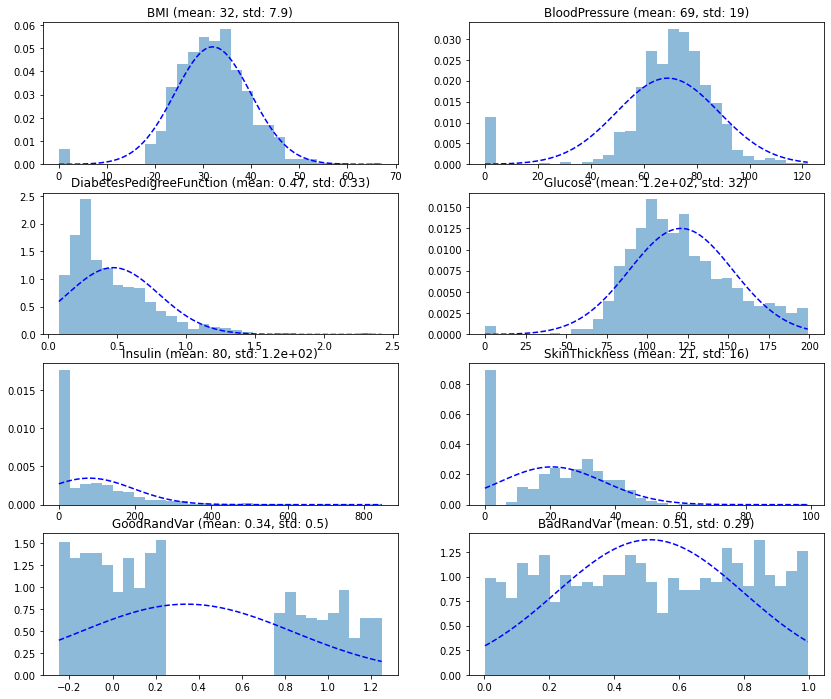

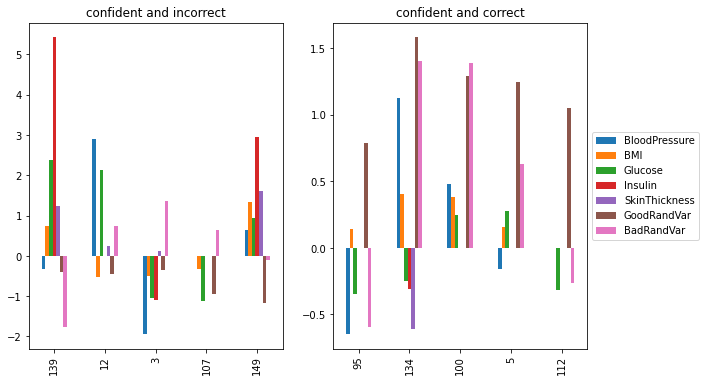

In [5]:
mg.run_magec(diabetes_fpath, cols_to_corr_new_feature=['Outcome'])

We see that the GoodRandVar dilutes the importance of all other features that can be intervenable. The Random Forest classifier shows that this artifial feature is the most importance, and this is agreed upon by all the individual and combined MAgEC models.

This observation raises a red flag, in that a single feature is overwhelmingly more important than any other feature at predicting the Outcome. An astute scientist would notice this and demand further examination of this feature.

### Scenario 3

Here we introduce a new feature that is linearly correlated to the most important feature from the baseline scenario (Glucose), with some noise. Again, we call this feature GoodRandVar and also include the BadRandVar. This GoodRandVar artificial feature can represent data error (where one feature is essentially replicated onto another feature) or a non-independent measurement that is essentially measuring the values of another feature.

Sorted feature importance from Random Forest Classifier:
0.17663407615356116 -- GoodRandVar
0.15621967242001955 -- Glucose
0.13654213151160285 -- BMI
0.10312622796446005 -- DiabetesPedigreeFunction
0.10090774863077322 -- Age
0.08396694330597075 -- BadRandVar
0.06682081633325414 -- Insulin
0.05977586569934692 -- BloodPressure
0.059732610772576945 -- SkinThickness
0.05627390720843451 -- Pregnancies
----------------------------------------------------------------------

MAgEC feature importance by mlp model:
For diabetic individuals
               mlp_magec_1
mlp_feat_1                
Glucose          -0.566887
BadRandVar       -0.432125
SkinThickness    -0.381817
BMI              -0.371948
Insulin          -0.361793
BloodPressure    -0.216894

For non-diabetic individuals
               mlp_magec_1
mlp_feat_1                
Glucose          -0.416287
BadRandVar       -0.398144
BMI              -0.394929
SkinThickness    -0.311552
BloodPressure    -0.193884
Insulin          -0.183496
no

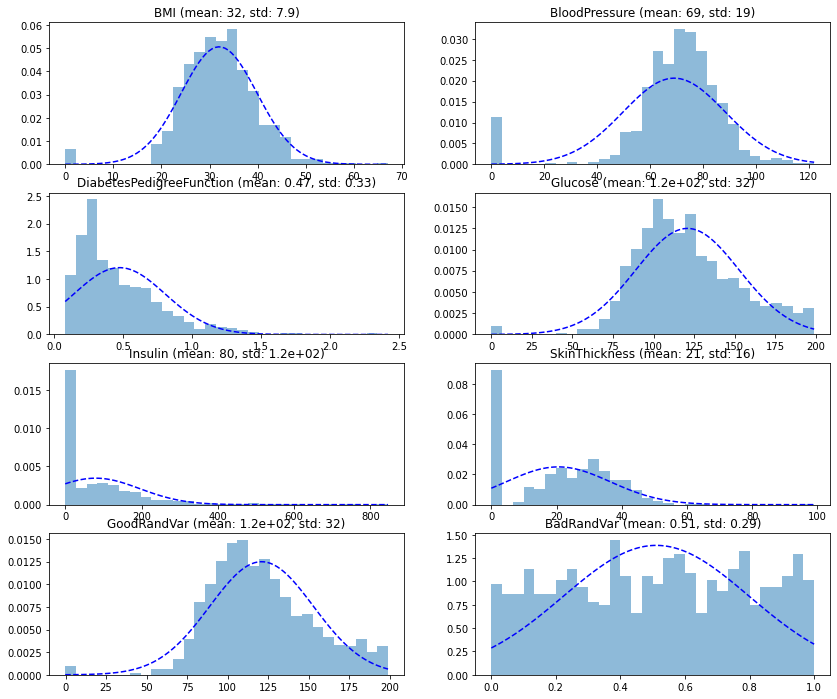

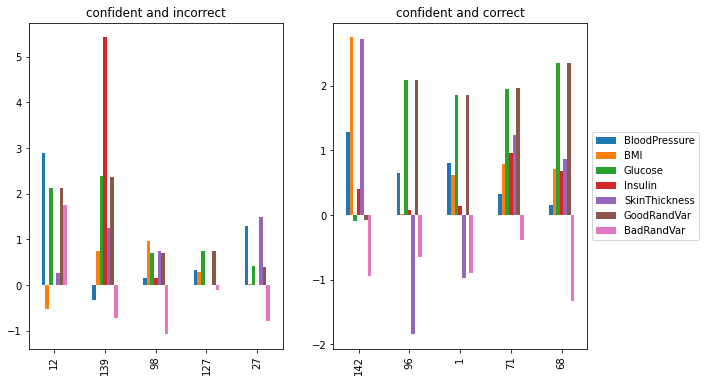

In [6]:
mg.run_magec(diabetes_fpath, cols_to_corr_new_feature=['Glucose'])

Here we see that while the artificial variable is similar in distribution to Glucose, and that the Random Forest Classifier picks this variable to be the most important, each non-linear model's MAgEC importance and the combined MAgEC importance show a greater importance to the real features. This demonstrates the ability of MAgEC to incorporate the qualities of all models and choose real features to deem important to intervene on. However, in this case the combined MAgEC score still ranks the artificial feature to having some importance.

### Scenario 4

Here we introduce a new feature that is non-linearly correlated using the 3 most important feature from the baseline scenario (Glucose, BMI, Insulin), with some noise. This GoodRandVar artificial feature can represent confounding variables that are non-independent measurement of multiple variables.

Sorted feature importance from Random Forest Classifier:
0.17647054063707956 -- GoodRandVar
0.1542887900668893 -- Glucose
0.13355080370303252 -- BMI
0.10040772364605541 -- DiabetesPedigreeFunction
0.0994625843988081 -- Age
0.09779225339981171 -- BadRandVar
0.06536657398296007 -- Insulin
0.059353857721265085 -- SkinThickness
0.057870873251754454 -- BloodPressure
0.0554359991923437 -- Pregnancies
----------------------------------------------------------------------

MAgEC feature importance by mlp model:
For diabetic individuals
               mlp_magec_1
mlp_feat_1                
Glucose          -0.610102
BMI              -0.562544
GoodRandVar      -0.533444
BadRandVar       -0.471399
Insulin          -0.451120
SkinThickness    -0.225621

For non-diabetic individuals
               mlp_magec_1
mlp_feat_1                
Glucose          -0.449411
BadRandVar       -0.448804
BMI              -0.328579
Insulin          -0.233972
BloodPressure    -0.189277
SkinThickness    -0.169506
not_

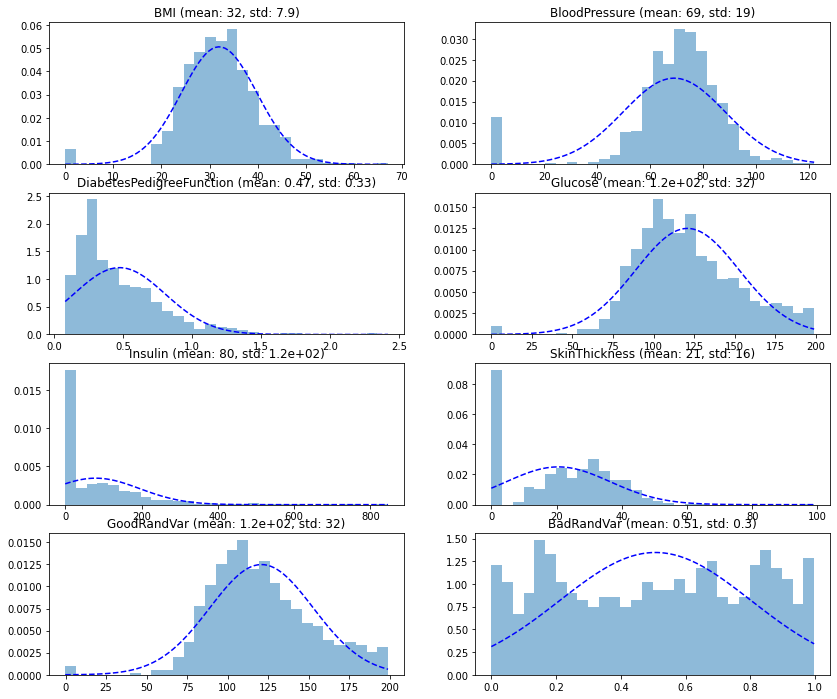

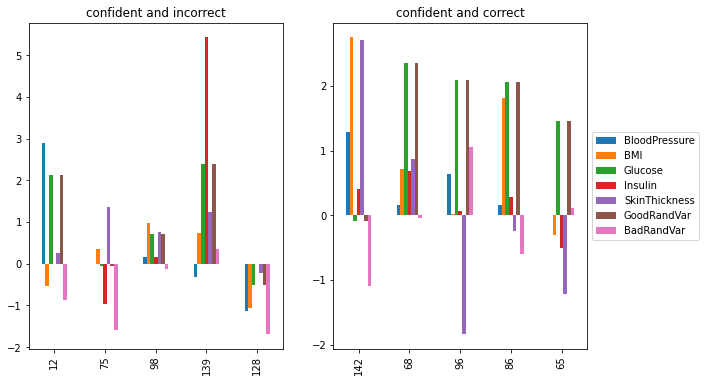

In [7]:
mg.run_magec(diabetes_fpath, cols_to_corr_new_feature=['Glucose', 'BMI', 'Insulin'])

Again, the Random Forest Classifier is fooled into giving the artificial variable the most importance, however the other models are generally not. When observing the combined MAgEC scores, the artificial variable does not even rank as being important, meaning this variable was never used as a top performer in any case. This demonstrates that MAgEC is useful at finding real features to intervene on, even when the artificial feature has a non-linear relationship.